	@article{He2015,
		author = {Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun},
		title = {Deep Residual Learning for Image Recognition},
		journal = {arXiv preprint arXiv:1512.03385},
		year = {2015}
	}


## Importing Libraries


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

##Creating data generator

In [ ]:
batch_size = 32
epochs = 50
num_classes=10

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=len(labels)+1)
  dataset = dataset.batch(batch_size=batch_size,
                          drop_remainder=True)
  dataset = dataset.repeat()
  #dataset = dataset.preftech(tf.data.experimental.AUTOTUNE)
  return dataset


170500096/170498071 [==============================] - 18s 0us/step


## Visualizing Input Images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


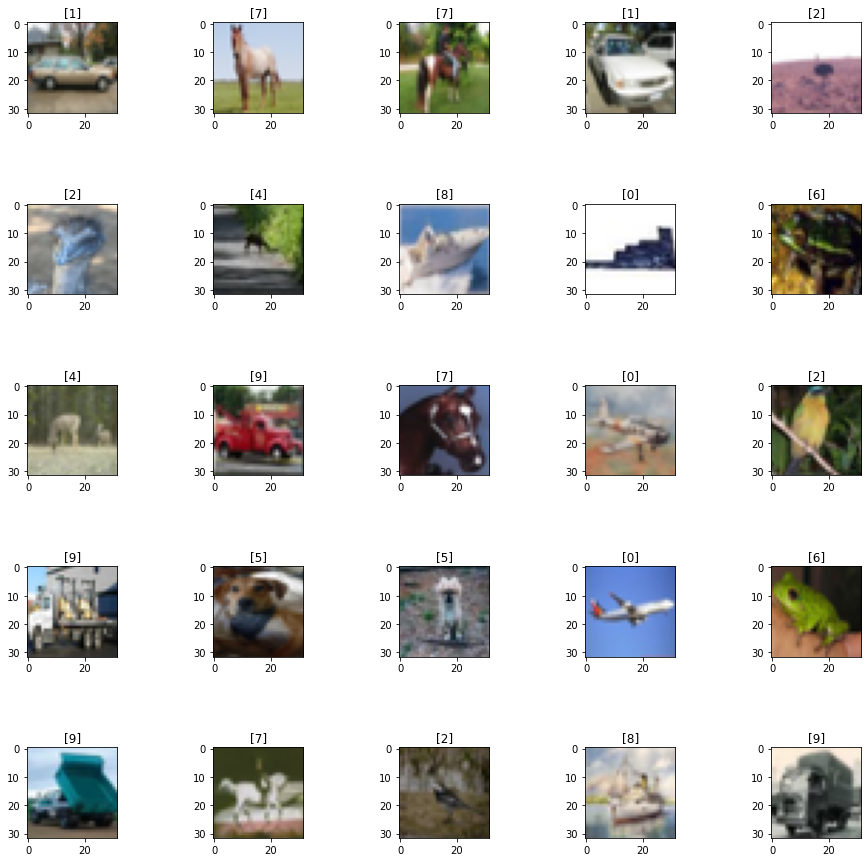

In [ ]:
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(25):
    for val in dataset.take(1):
      plt.subplot(5,5,i+1)
      plt.imshow((val[0][i]))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(wspace=1, hspace=1)
  plt.show()

train_dataset = data_generator(x_train,y_train)
test_dataset = data_generator(x_test,y_test)
show_img(train_dataset)


##  ResNet 50

![alt text](https://cv-tricks.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png)

Image reference : https://cv-tricks.com/keras/understand-implement-resnets/

## Model

In [ ]:
def conv_block(input_layer,filters,strides,block):
  shortcut = input_layer
  layer = tf.keras.layers.Conv2D(filters,kernel_size=1, strides=strides,
                    kernel_initializer='he_normal')(input_layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same',strides=1,
                    kernel_initializer='he_normal')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(filters*4, kernel_size=1,strides=1,
                    kernel_initializer='he_normal')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)

  if block == 'a':
    shortcut = tf.keras.layers.Conv2D(filters*4, kernel_size=1, strides=strides,
                              kernel_initializer='he_normal')(input_layer)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

  layer = tf.keras.layers.add([layer, shortcut])
  layer = tf.keras.layers.ReLU()(layer)
  return layer


In [ ]:
def ResNet50(input_shape=[None,None,3],
             include_top=True):
  model_input = tf.keras.layers.Input(shape=input_shape)
  
  layer = tf.keras.layers.Conv2D(filters=64,
                                 strides=2,
                                 padding='valid',
                                 kernel_size=7,
                                kernel_initializer='he_normal')(model_input)
  layer = tf.keras.layers.BatchNormalization(axis=3)(layer)
  layer = tf.keras.layers.Activation('relu')(layer)
  layer = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),
                                       strides=(2, 2))(layer)

  #Stage 1
  layer = conv_block(layer,filters=64,strides=1,block='a')
  layer = conv_block(layer,filters=64,strides=1,block='b')
  layer = conv_block(layer,filters=64,strides=1,block='c')

  #Stage 2
  layer = conv_block(layer,filters=128,strides=2,block='a')
  layer = conv_block(layer,filters=128,strides=1,block='b')
  layer = conv_block(layer,filters=128,strides=1,block='c')
  layer = conv_block(layer,filters=128,strides=1,block='d')  

  #Stage 3
  layer = conv_block(layer,filters=256,strides=2,block='a')
  layer = conv_block(layer,filters=256,strides=1,block='b')
  layer = conv_block(layer,filters=256,strides=1,block='c')
  layer = conv_block(layer,filters=256,strides=1,block='d')
  layer = conv_block(layer,filters=256,strides=1,block='e')
  layer = conv_block(layer,filters=256,strides=1,block='f')

  #Stage 4
  layer = conv_block(layer,filters=512,strides=2,block='a')
  layer = conv_block(layer,filters=512,strides=1,block='b')
  layer = conv_block(layer,filters=512,strides=1,block='c')
  
  layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
  layer = tf.keras.layers.Dense(1000)(layer)
  if include_top:
      layer = tf.keras.layers.Dense(units=num_classes)(layer)
  return tf.keras.Model(inputs=model_input, outputs=layer, name='ResNet50')


In [ ]:
learning_rate_fn = tfa.optimizers.TriangularCyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-1,
    step_size=100,
    scale_mode="cycle")

In [ ]:
model = ResNet50(input_shape=(32,32,3),include_top=True)


model.compile(loss=tf.losses.SparseCategoricalCrossentropy
              (from_logits=True), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate_fn), 
              metrics=[tf.metrics.SparseCategoricalAccuracy()])


callbacks = [
    tf.keras.callbacks.ModelCheckpoint('resnet_model03.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='sparse_categorical_accuracy')]

model.fit_generator(train_dataset,
          steps_per_epoch=len(x_train) // batch_size,
          epochs=epochs,
          callbacks=callbacks)


Epoch 1/50
1562/1562 [==============================] - 46s 29ms/step - loss: 2.4049 - sparse_categorical_accuracy: 0.2663
Epoch 2/50
1562/1562 [==============================] - 46s 29ms/step - loss: 1.9134 - sparse_categorical_accuracy: 0.3292
Epoch 3/50
1562/1562 [==============================] - 46s 29ms/step - loss: 1.7628 - sparse_categorical_accuracy: 0.3895
Epoch 4/50
1562/1562 [==============================] - 46s 29ms/step - loss: 1.6463 - sparse_categorical_accuracy: 0.4335
Epoch 5/50
1562/1562 [==============================] - 46s 30ms/step - loss: 1.5571 - sparse_categorical_accuracy: 0.4719
Epoch 6/50
1562/1562 [==============================] - 46s 30ms/step - loss: 1.4576 - sparse_categorical_accuracy: 0.5092
Epoch 7/50
1562/1562 [==============================] - 46s 29ms/step - loss: 1.3530 - sparse_categorical_accuracy: 0.5404
Epoch 8/50
1562/1562 [==============================] - 46s 30ms/step - loss: 1.2907 - sparse_categorical_accuracy: 0.5652
Epoch 9/50
1562/

## Inference

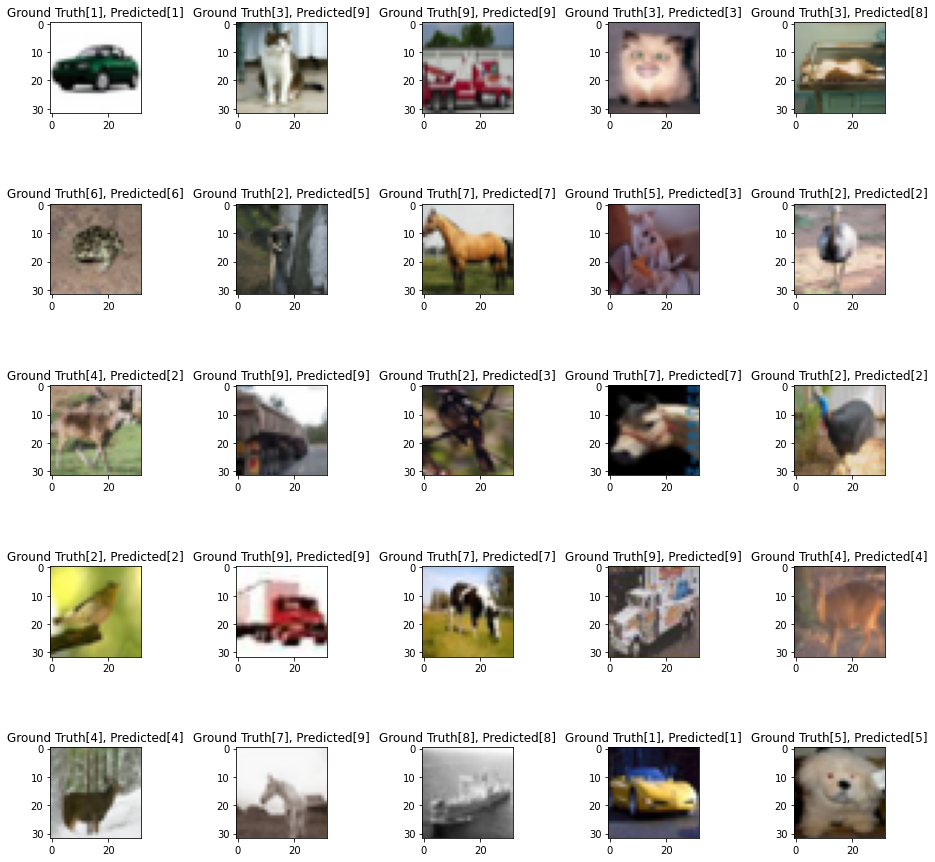

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
  for val in test_dataset.take(1):
    plt.subplot(5,5,i+1)
    plt.imshow((val[0][i]))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    
    plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()
